In [1]:
!rm -rdf __pycache__ *.pyc

import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from bnn import BayesianNeuralNetwork, KLDivergence
from torchvision import datasets, transforms

epochs = 20
batch_size = 256
learning_rate = 1e-3
validation_frequency = 100
samples = 50

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=batch_size, shuffle=True)

n_batches = int(np.ceil(len(train_loader.dataset) / batch_size))


In [3]:
model = BayesianNeuralNetwork(784, 10).to(device)
loss_function = torch.nn.CrossEntropyLoss()
kld = KLDivergence(n_batches)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [4]:
def plot_lines(df, columns, colors, ax, alpha=0.25, show_range=False, window_size=1):
    for color, column in zip(colors, columns):
        agg_df = df.groupby('epoch')[column]

        if window_size > 1:
            agg_df = agg_df.mean().rolling(window_size, min_periods=1)

        means = agg_df.mean()
        ax.plot(np.arange(len(means)), means, c=color)

        if show_range:
            mins = agg_df.min()
            maxs = agg_df.max()
            ax.fill_between(x=np.arange(len(means)),
                            y1=mins, y2=maxs, alpha=alpha)

    ax.legend(columns)

In [5]:
def entropy(x):
    return -(x * torch.log(x + 1e-10)).sum(dim=-1)

epoch: 100%|██████████| 20/20 [38:26<00:00, 109.47s/it, loss: 1.5087, entropy: 0.0070, test_loss: 1.5419, test_accuracy: 0.9230]


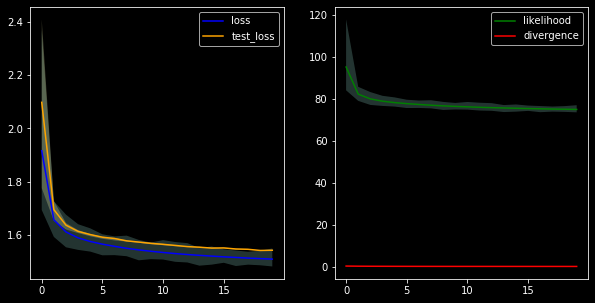

In [6]:
history = pd.DataFrame()

epochs_logger = tqdm(range(1, epochs + 1), desc='epoch', position=0, leave=True) 
for epoch in epochs_logger:
    steps_logger = tqdm(train_loader, desc='step', total=n_batches, position=0, leave=True) 
    for step, (x, y) in enumerate(steps_logger):
        model.train()

        x, y = x.to(device), y.to(device)
        x = x.view(x.shape[0], -1)
        optimizer.zero_grad()

        preds = []
        likelihood = 0
        divergence = 0
        for _ in range(samples):
            pred = model(x)
            preds.append(pred)
            likelihood += loss_function(pred, y)
            divergence += kld(model)

        loss = (likelihood + divergence) / samples
        loss.backward()
        optimizer.step()
        ent = entropy(torch.stack(preds, dim=-1))

        if step % validation_frequency == 0:
            # todo idk why but the behaviour is weird
            model.eval()
            test_loss = 0
            test_accuracy = 0
            with torch.no_grad():
                for test_x, test_y in test_loader:
                    test_x, test_y = test_x.to(device), test_y.to(device)
                    test_x = test_x.view(test_x.shape[0], -1)

                    test_preds = []
                    for _ in range(samples):
                        test_pred = model(test_x)
                        test_loss += loss_function(test_pred, test_y)
                        test_preds.append(test_pred)

                    test_accuracy += (torch.stack(test_preds, dim=-1).prod(dim=-1).argmax(dim=-1) == test_y).to(torch.float).mean()

            test_loss /= (len(test_loader.dataset) / batch_size) * samples
            test_accuracy /= (len(test_loader.dataset) / batch_size)
            
        history = history.append({
            'epoch': epoch,
            'step': step,
            'loss': loss.item(),
            'entropy': ent.mean().item(),
            'likelihood': likelihood.item(),
            'divergence': divergence.item(),
            'test_loss': test_loss.item(),
            'test_accuracy': test_accuracy.item()
        }, ignore_index=True)

        history_for_this_epoch = history.query(f'epoch == {epoch}')
        mean_values = history_for_this_epoch.mean(axis=0)
        mean_loss = mean_values['loss']
        mean_entropy = mean_values['entropy']
        mean_likelihood = mean_values['likelihood']
        mean_divergence = mean_values['divergence']
        mean_test_loss = mean_values['test_loss']
        mean_test_accuracy = mean_values['test_accuracy']

        log_str = f'loss: {mean_loss:.4f}, entropy: {mean_entropy:.4f}, test_loss: {mean_test_loss:.4f}, test_accuracy: {mean_test_accuracy:.4f}'
        steps_logger.set_postfix_str(log_str)
    epochs_logger.set_postfix_str(log_str)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_lines(history, ['loss', 'test_loss'], ['blue', 'orange'], axs[0], show_range=True)
plot_lines(history, ['likelihood', 'divergence'], ['green', 'red'], axs[1], show_range=True)

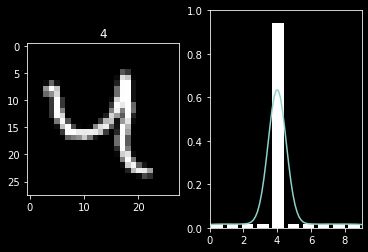

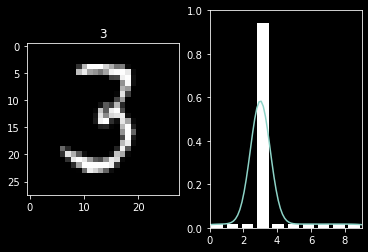

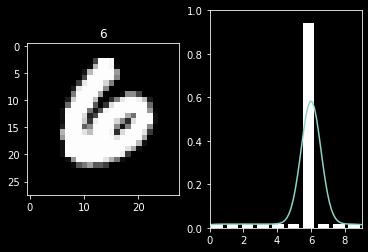

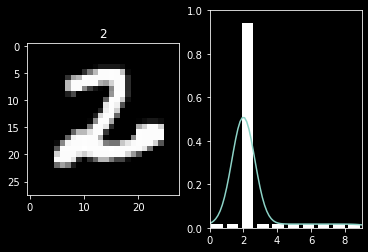

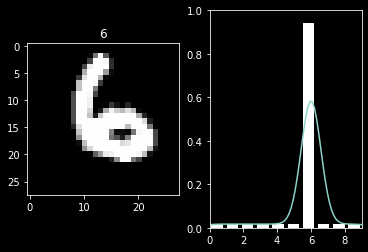

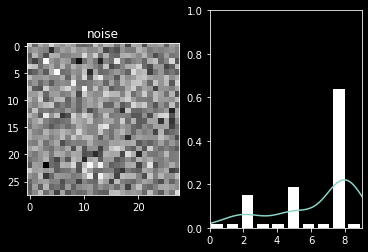

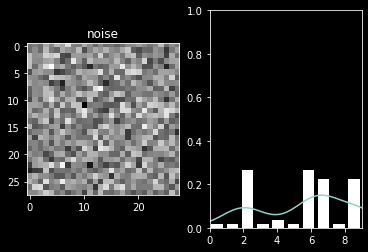

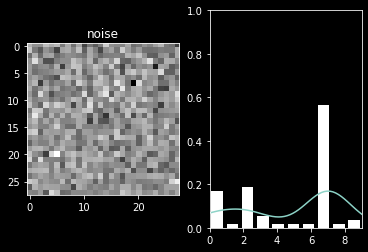

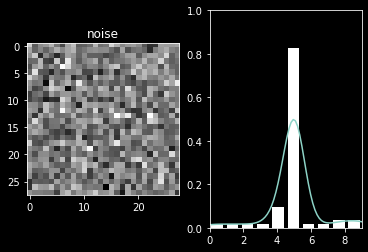

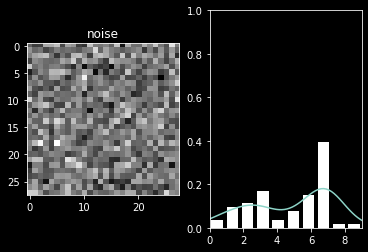

In [7]:
def plot_preds(im, label, model):
    preds = np.argmax([model(im.view(784)).cpu().numpy()
             for _ in range(samples-1)], axis=1)
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(im.cpu().numpy(), [1, 2, 0])[:, :, 0], cmap='gray')
    plt.title(label)
    plt.subplot(1, 2, 2)
    sns.distplot(np.concatenate([np.arange(0, 10), preds]), bins=10,
    hist_kws={"rwidth":0.75, 'color': 'w', 'alpha':1.0})
    plt.ylim(0, 1)
    plt.xlim(0, 9)

n = 5
with torch.no_grad():
    images, labels = next(iter(test_loader))
    images, labels = images[:n], labels[:n]
    for im, target in zip(images, labels):
        plot_preds(im.to(device), target.cpu().numpy(), model)
        plt.show()
    for _ in range(n):
        plot_preds(torch.randn(1, 28, 28).to(device), 'noise', model)
        plt.show()

